## Perch

Downloaded Path : C:\Users\zzannzini\.cache\kagglehub\models\google\bird-vocalization-classifier\tensorFlow2\bird-vocalization-classifier\8


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.model_download("google/bird-vocalization-classifier/tensorFlow2/bird-vocalization-classifier")

print("Path to model files:", path)

In [3]:
import time
START = time.time()

from concurrent.futures import ThreadPoolExecutor
import glob
import librosa
import numpy as np
import os
import pandas as pd
import re
import sys
import tensorflow as tf

tf.experimental.numpy.experimental_enable_numpy_behavior()

TERMINATE_TIME = START + 5300

In [4]:
birdclassifier = tf.saved_model.load(path)

In [21]:
class Config:
 
    DEBUG_MODE = True
    
    OUTPUT_DIR = './working/'
    DATA_ROOT = './Data'
    FS = 32000

    EMBEDDING = True 
    # get embedding data
    
    # Mel spectrogram parameters
    #N_FFT = 1024
    #HOP_LENGTH = 512
    #N_MELS = 128
    #FMIN = 50
    #FMAX = 14000
    
    #TARGET_DURATION = 5.0
    #TARGET_SHAPE = (256, 256)  
    
    #N_MAX = 50 if DEBUG_MODE else None  

config = Config()

### Get the map from common bird name to dataframe index

In [6]:
primary_labels = pd.read_csv(config.DATA_ROOT + '/sample_submission.csv').columns[1:].to_list()
primary_labels_indices = range(len(primary_labels))

primary_labels_map = dict(zip(primary_labels, primary_labels_indices))

taxonomy = pd.read_csv(config.DATA_ROOT+'/taxonomy.csv', index_col='common_name')['primary_label']
taxonomy_map = taxonomy.map(primary_labels_map)

common_names = taxonomy.index.to_list()

In [7]:
bc_labels = pd.read_csv(path + '/assets/label.csv').iloc[:, 0].to_list()
bc_labels_indices = range(len(bc_labels))

primary_labels_map = dict(zip(bc_labels, bc_labels_indices))

birdclassifier_last = len(bc_labels)
birdclassifier_indices = [primary_labels_map[pl] if pl in bc_labels else birdclassifier_last for pl in primary_labels]

In [8]:
total_predicted_species = sum([pl in bc_labels for pl in primary_labels])
print(f'Note: we can predict {total_predicted_species} species only!')

Note: we can predict 143 species only!


### Get all the data files

In [55]:
def get_oggs(max_oggs=1):
    if len(glob.glob(config.DATA_ROOT+'/test_soundscapes/*.ogg')) > 0:
        oggs = glob.glob(config.DATA_ROOT+'/test_soundscapes/*.ogg')
    else:
        oggs = sorted(glob.glob(config.DATA_ROOT + f'/train_soundscapes/*.ogg'))[:max_oggs]
    return [(n, ogg, re.search(r'/([^/]+)\.ogg$', ogg).group(1)) for n, ogg in enumerate(oggs)]

oggs = get_oggs()

### Process the files in threads

In [62]:
def bvc_result(ogg):
    _, fname, ss_id = ogg
    sr = 32_000

    print(f'{ss_id}')
    row_ids = [f'{ss_id}_{n}' for n in range(5, 65, 5)]

    if time.time() > TERMINATE_TIME:
        return row_ids, -1000 * np.ones((12, 206))
        
    data, _ = librosa.load(fname, sr=sr)

    model_infer = birdclassifier.infer_tf(data.reshape((-1, 5 * sr)))
    #print(model_infer)
    print(model_infer.keys())

    if config.EMBEDDING :
        model_outputs = model_infer['embedding']
        result = model_outputs

    else :
        model_outputs = model_infer['label']
        model_outputs = tf.pad(model_outputs, tf.constant([[0, 0], [0, 1]]))
        result = model_outputs[:, birdclassifier_indices]

    return row_ids, result

In [67]:
row_ids = []
result = []

with ThreadPoolExecutor(max_workers=4) as executor:
    for ogg_row_ids, ogg_result in executor.map(bvc_result, oggs):
        row_ids += ogg_row_ids
        result.append(ogg_result)

train_soundscapes\H02_20230420_074000


### Visualize Embedding Vector using PCA (axes = 3)

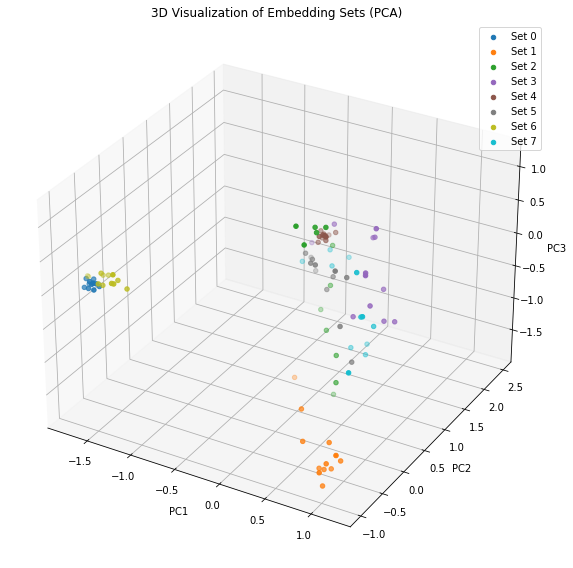

In [47]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# 예시: (12, 1280)짜리 텐서 여러 개 만들기 (총 3개의 소리 샘플)
num_samples = 8  # 3개의 소리
embedding_list = result

# 모든 데이터를 하나로 합쳐서 PCA 수행
all_embeddings = np.concatenate(embedding_list, axis=0)  # shape: (36, 1280)
pca = PCA(n_components=3)
all_embeddings_3d = pca.fit_transform(all_embeddings)    # shape: (36, 3)

# 색상 설정
colors = plt.cm.get_cmap("tab10", num_samples)

# 3D 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

start = 0
for i, embedding_set in enumerate(embedding_list):
    end = start + embedding_set.shape[0]
    points = all_embeddings_3d[start:end]
    ax.scatter(points[:, 0], points[:, 1], points[:, 2],
               color=colors(i), label=f"Set {i}")
    start = end

ax.set_title("3D Visualization of Embedding Sets (PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.tight_layout()
plt.show()

In [52]:
submission = pd.DataFrame(np.concatenate(result), columns = list(range(1280))
)
submission['row_id'] = row_ids
submission = submission[['row_id'] + list(range(1280))
]

In [12]:
submission = pd.DataFrame(np.concatenate(result), columns=primary_labels)
submission['row_id'] = row_ids
submission = submission[['row_id'] + primary_labels]

In [ ]:
# Write CSV
submission.to_csv('submission_embedding.csv', index=False)

# Display submission DataFrame
display(submission.head(20))

display(submission.tail(20))

In [61]:
# Write CSV
submission.to_csv('submission.csv', index=False)

# Display submission DataFrame
display(submission.head(20))

display(submission.tail(20))


,row_id,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,train_soundscapes\H02_20230420_074000_5,-0.022291,0.091989,0.021840,0.010768,-0.076425,0.029841,-0.002122,0.009005,0.029532,...,0.000358,-0.006751,-0.019676,-0.040610,0.006799,0.040718,0.194718,0.027771,-0.077784,-0.005282
1,train_soundscapes\H02_20230420_074000_10,-0.026940,0.084591,0.047250,0.011207,-0.058137,0.057911,0.011501,0.002056,0.071718,...,-0.018766,0.003530,0.018133,-0.065167,0.003574,0.070959,0.123480,0.055682,-0.016501,-0.014370
2,train_soundscapes\H02_20230420_074000_15,-0.023408,0.117083,0.044475,0.031375,-0.039473,0.121950,0.041716,0.001470,0.032201,...,-0.040567,-0.000280,0.062167,-0.066060,0.015670,0.024745,0.088645,0.033710,-0.051224,-0.016361
3,train_soundscapes\H02_20230420_074000_20,-0.048177,0.045562,0.017565,0.011861,-0.043838,0.100526,0.007979,-0.014079,0.043055,...,-0.038827,-0.006028,0.060386,-0.034672,0.020138,0.040025,0.110317,0.081894,-0.061489,-0.019583
4,train_soundscapes\H02_20230420_074000_25,0.012592,0.112372,0.020150,0.010471,-0.080657,0.119198,0.015470,-0.002140,0.052783,...,-0.021964,-0.002507,0.007390,-0.036043,0.024975,0.042005,0.108660,0.063637,-0.013508,-0.015557
5,train_soundscapes\H02_20230420_074000_30,-0.022030,0.045619,0.057767,0.018928,-0.053707,0.034530,0.011783,0.004897,0.025921,...,-0.026362,-0.003614,0.109363,-0.027731,0.007456,0.030609,0.086896,0.059755,-0.068943,-0.020920
6,train_soundscapes\H02_20230420_074000_35,0.049480,0.080142,0.029794,0.008448,-0.091494,0.003641,0.030314,-0.022882,0.045238,...,-0.048711,-0.005867,0.076206,-0.076990,0.012004,0.035587,0.129958,0.021253,-0.039006,-0.018350
7,train_soundscapes\H02_20230420_074000_40,-0.006239,0.039377,0.032252,0.005961,-0.044255,0.089565,0.001435,0.020196,0.034129,...,-0.024589,-0.011040,0.006787,-0.069118,0.015221,0.066042,0.160829,0.036908,-0.091832,-0.017820
8,train_soundscapes\H02_20230420_074000_45,0.016161,0.057470,0.021240,-0.012261,-0.039831,0.023307,0.027301,-0.042326,0.042469,...,0.010091,-0.008334,0.020830,-0.009173,0.009130,0.025404,0.121859,0.015905,-0.131453,0.011037
9,train_soundscapes\H02_20230420_074000_50,0.012617,0.075990,0.024974,-0.006149,-0.025862,0.069082,0.001682,0.012732,0.054565,...,-0.030579,-0.010165,0.021533,-0.034865,0.008691,0.046031,0.119677,0.030195,-0.094798,-0.007079


,row_id,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
76,train_soundscapes\H02_20230421_113500_25,0.018649,-0.009583,0.027363,-0.000909,0.012604,-0.032926,-0.007232,0.020051,0.040852,...,0.003118,-0.013568,0.053058,-0.013635,-0.005716,0.036365,0.048464,0.033441,-0.069304,-0.011315
77,train_soundscapes\H02_20230421_113500_30,0.033579,0.096343,0.011592,0.022917,-0.030083,0.030112,0.000725,0.009355,0.046141,...,-0.004724,-0.016715,0.015673,0.028507,-0.001851,0.056215,0.043057,0.009624,-0.063945,-0.011600
78,train_soundscapes\H02_20230421_113500_35,-0.009036,-0.116866,0.023322,0.012999,-0.004637,0.024355,-0.011752,0.015729,0.024071,...,0.014911,-0.009406,-0.000800,-0.029472,-0.004941,0.024030,0.111929,0.025942,0.005548,-0.018176
79,train_soundscapes\H02_20230421_113500_40,-0.010966,0.005351,0.018532,0.011739,0.041556,-0.041473,-0.011576,-0.004918,0.047173,...,0.004433,-0.017970,0.054213,-0.047364,0.020415,0.040334,-0.040711,0.031169,-0.001643,-0.002937
80,train_soundscapes\H02_20230421_113500_45,0.060992,-0.045281,0.127144,-0.000439,0.030521,0.003584,-0.017907,0.043701,0.027436,...,0.020722,-0.010153,0.153554,-0.061268,0.019978,0.037644,0.078309,0.043210,0.033721,-0.017673
81,train_soundscapes\H02_20230421_113500_50,0.040850,-0.045406,0.067547,0.004804,-0.011377,-0.048247,-0.015739,0.057373,0.044551,...,0.002194,-0.012984,0.045949,-0.080019,0.006315,0.030434,0.037907,0.041556,-0.030583,-0.018016
82,train_soundscapes\H02_20230421_113500_55,-0.033779,-0.034750,0.017889,-0.006474,-0.038065,-0.044302,0.008915,0.005423,0.045896,...,0.040688,-0.009904,0.028758,-0.033670,-0.001384,0.047857,0.035271,0.034818,-0.014041,0.001794
83,train_soundscapes\H02_20230421_113500_60,0.065097,-0.088165,0.015043,-0.006463,-0.023970,0.007664,-0.010342,-0.001274,0.054131,...,0.018704,-0.012749,0.052445,-0.062055,0.003491,0.065727,0.059926,0.029891,-0.007018,0.004782
84,train_soundscapes\H02_20230421_170000_5,-0.088444,-0.020304,0.042333,0.011125,-0.013672,0.040930,-0.001042,0.008817,0.068649,...,-0.031475,-0.001287,0.018809,0.162893,0.009943,-0.008430,0.140263,0.151650,-0.155585,-0.021285
85,train_soundscapes\H02_20230421_170000_10,-0.051694,0.105731,0.045714,-0.023500,-0.057262,-0.063914,0.015658,-0.065153,0.025097,...,-0.060216,-0.002202,0.089399,0.131070,-0.024991,0.055502,0.306364,-0.005825,-0.087620,-0.023657
